In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import seaborn as sns
from pipeline import Pipeline
from rnn import RNN
from datetime import datetime
import json
import matplotlib.pyplot as plt

### Load datasets

In [2]:
df_train = pd.read_csv("./data/train.csv")
df_valid = pd.read_csv("./data/valid.csv")

#### Process datasets

In [3]:
df_train, train_scale = Pipeline.process(data=df_train, altered=True)
df_valid, valid_scale = Pipeline.process(data=df_valid, altered=True)
df_test = df_valid[len(df_valid)//2:]
df_valid = df_valid[:len(df_valid)//2]

### Parameters
Select features and length of sequences (k)

In [4]:
k = 60
features=[
    'hydro', 
    'micro',
    'thermal',
    'wind', 
    'total',
    'sys_reg', 
    'flow', 
    'time_of_day_sin',
    'time_of_day_cos',
    'time_of_week_sin',
    'time_of_week_cos',
    'time_of_year_sin',
    'time_of_year_cos',
    'time_of_hour_sin',
    'time_of_hour_cos',
    'new_hour',
    'sum',
    'structural_imbalance',
    'prev_day_y',
    'prev_week_y',
    # 'previous_20y']
    'previous_y']
no_features = len(features)

Format data for RNN

In [5]:
x_train, y_train = Pipeline.format_data(df_train, k=k, features=features, noise_prev_no=k)
x_valid, y_valid = Pipeline.format_data(df_valid, k=k, features=features)
x_test, y_test = Pipeline.format_data(df_test, k=k, features=features)

### Build the model

In [6]:
model = RNN(k, no_features, altered=True)
model.model.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 21)]          0         
                                                                 
 lstm (LSTM)                 (None, 60, 30)            6240      
                                                                 
 dropout (Dropout)           (None, 60, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 20)            4080      
                                                                 
 dropout_1 (Dropout)         (None, 60, 20)            0         
                                                                 
 lstm_2 (LSTM)               (None, 25)                4600      
                                                                 
 dropout_2 (Dropout)         (None, 25)                0

### Train the model

In [7]:
model.train(
    x_train=x_train,
    y_train=y_train,
    x_valid=x_valid, 
    y_valid=y_valid,
    epochs=10,
    batch_size=128)

Epoch 1/10
1743/1743 [==============================] - 57s 26ms/step - loss: 0.3664 - val_loss: 0.3076
Epoch 2/10
1743/1743 [==============================] - 43s 25ms/step - loss: 0.2417 - val_loss: 0.2733
Epoch 3/10
1743/1743 [==============================] - 44s 25ms/step - loss: 0.2213 - val_loss: 0.2565
Epoch 4/10
1743/1743 [==============================] - 43s 25ms/step - loss: 0.2088 - val_loss: 0.2395
Epoch 5/10
1743/1743 [==============================] - 43s 25ms/step - loss: 0.1984 - val_loss: 0.2315
Epoch 6/10
1743/1743 [==============================] - 43s 25ms/step - loss: 0.1901 - val_loss: 0.2244
Epoch 7/10
1743/1743 [==============================] - 43s 25ms/step - loss: 0.1829 - val_loss: 0.2191
Epoch 8/10
1743/1743 [==============================] - 43s 25ms/step - loss: 0.1780 - val_loss: 0.2132
Epoch 9/10
1743/1743 [==============================] - 42s 24ms/step - loss: 0.1733 - val_loss: 0.2068
Epoch 10/10
1743/1743 [==============================] - 42s 24m

#### Plot training loss

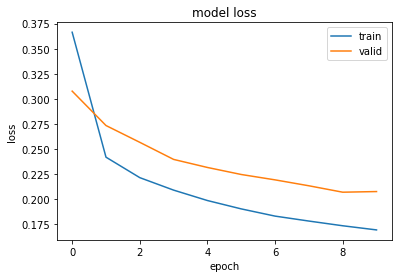

In [8]:
model.plot_train_history()

### Test model
Testing the model on different portions of the test set

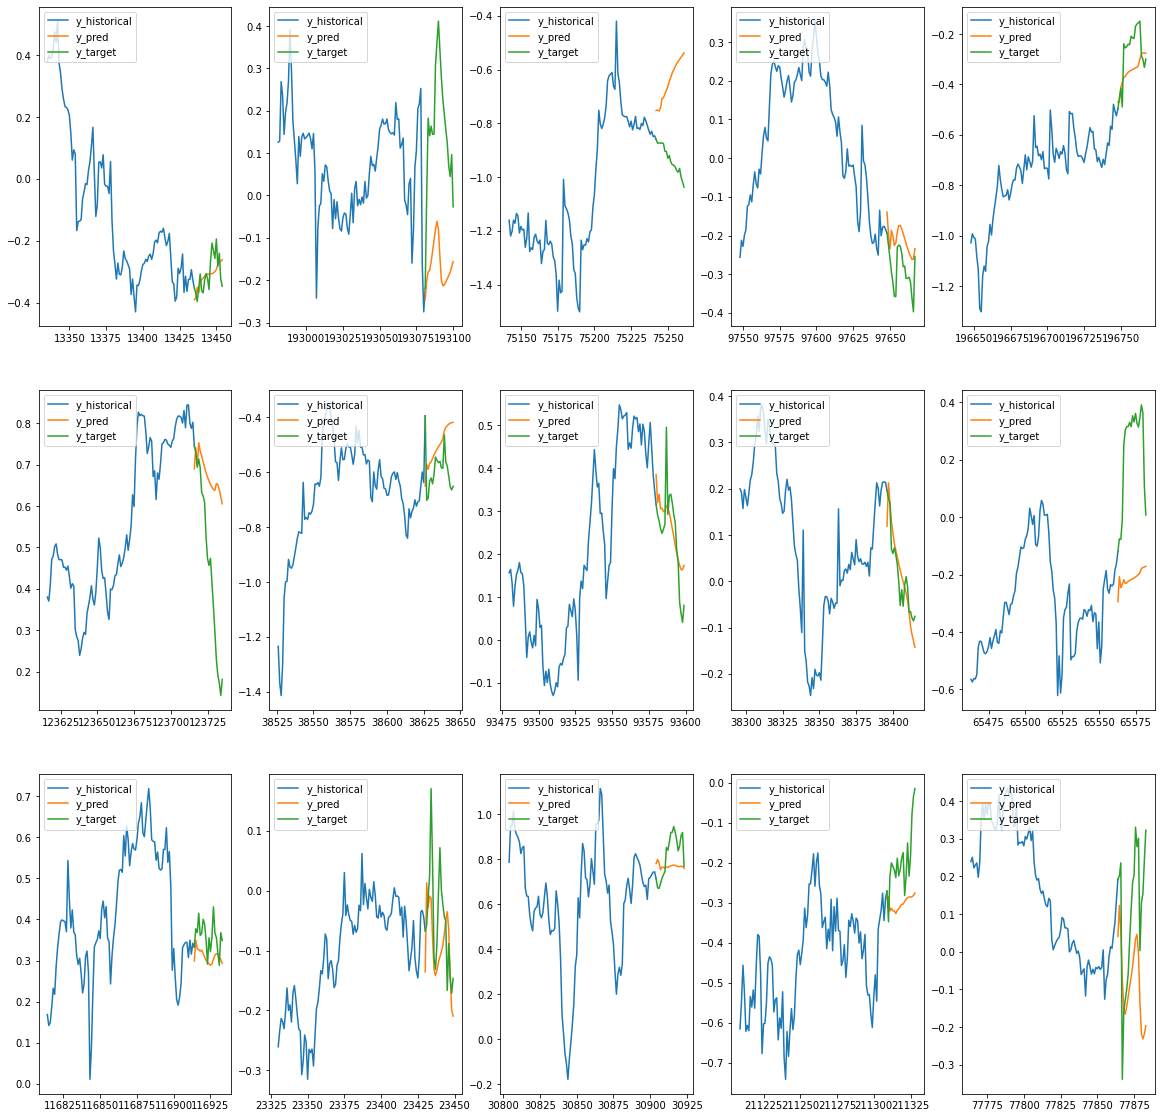

In [9]:
model.forecast_15(x_train, y_train, replace=True, path="./figures/train_set.png")

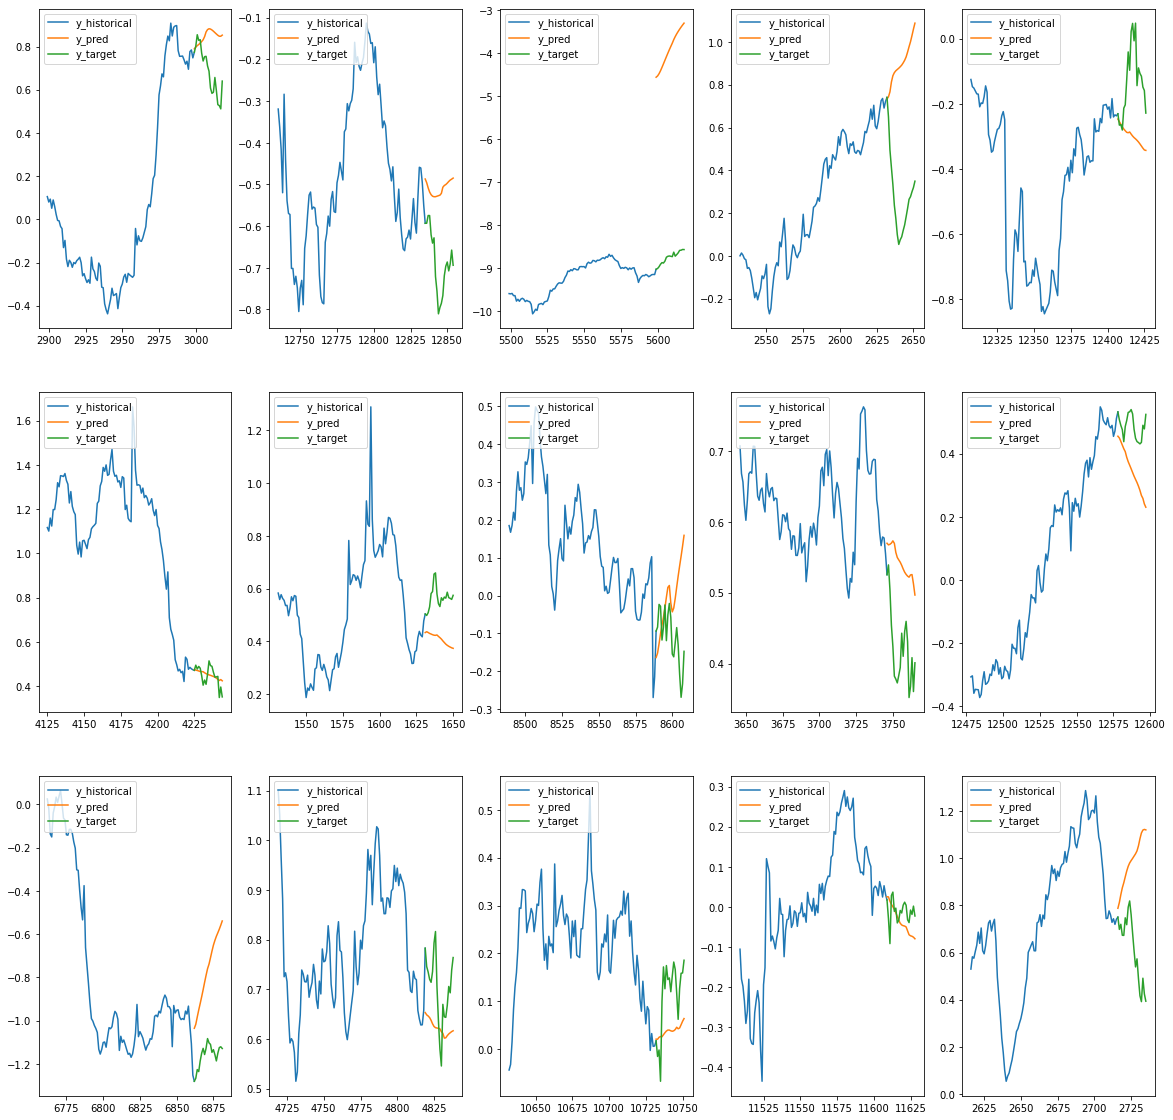

In [10]:
model.forecast_15(x_valid, y_valid,  replace=True, path="./figures/valid_set.png")

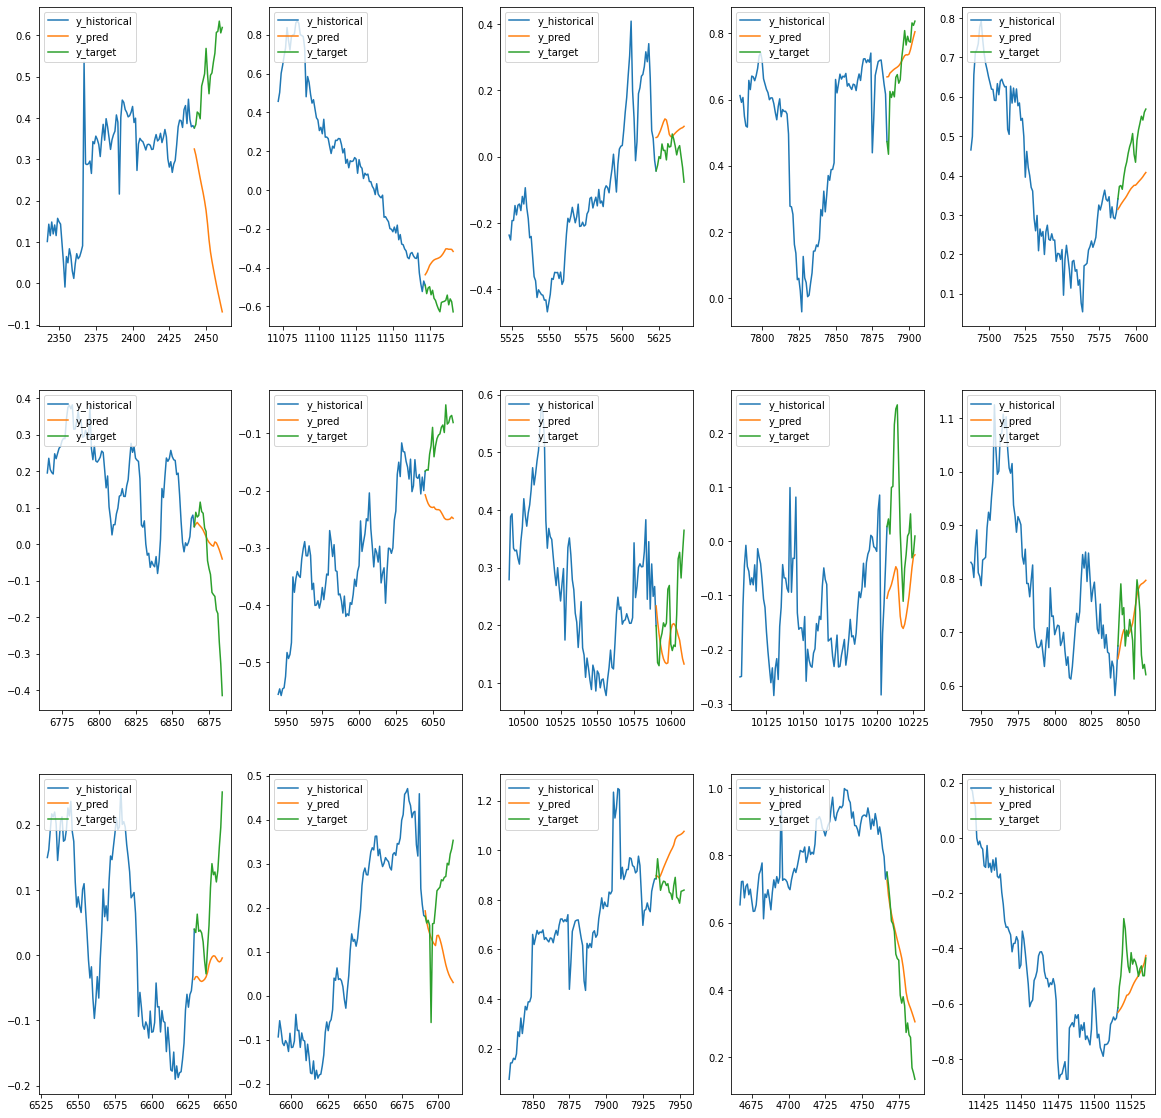

In [11]:
model.forecast_15(x_test, y_test, replace=True, path="./figures/test_set.png")

### Save model

In [35]:
comments = "Added random to every prev_y"

In [36]:
metadata = {'features': features, 'k':k, 'comments':comments}
timestamp = datetime.now().isoformat()[:19]
timestamp = timestamp.replace(":", "-")
path = f"models/{timestamp}_altered"
model.save_model(path=f"{path}/model")
with open(f"{path}/metadata.json", 'w') as f:
    json.dump(metadata, f)

INFO:tensorflow:Assets written to: models/2022-04-24T16-24-11_altered/model\assets


INFO:tensorflow:Assets written to: models/2022-04-24T16-24-11_altered/model\assets


#### Load model

In [3]:
path = "./models/2022-04-24T16-24-11_altered"

In [4]:
with open(f"{path}/metadata.json", 'r') as f:
    meta = json.load(f)
k = meta['k']
features = meta['features']

In [5]:
model = RNN(k, len(features), altered=True)

In [6]:
model.load_model(path=f"{path}/model", new_k=k)

### Load and prepare hold out set

In [7]:
df_t = pd.read_csv("./data/valid.csv")
df_t, train_scale = Pipeline.process(data=df_t, altered=True)

In [8]:
x_test, y_test = Pipeline.format_data(df_t, k=k, features=features)

Test model

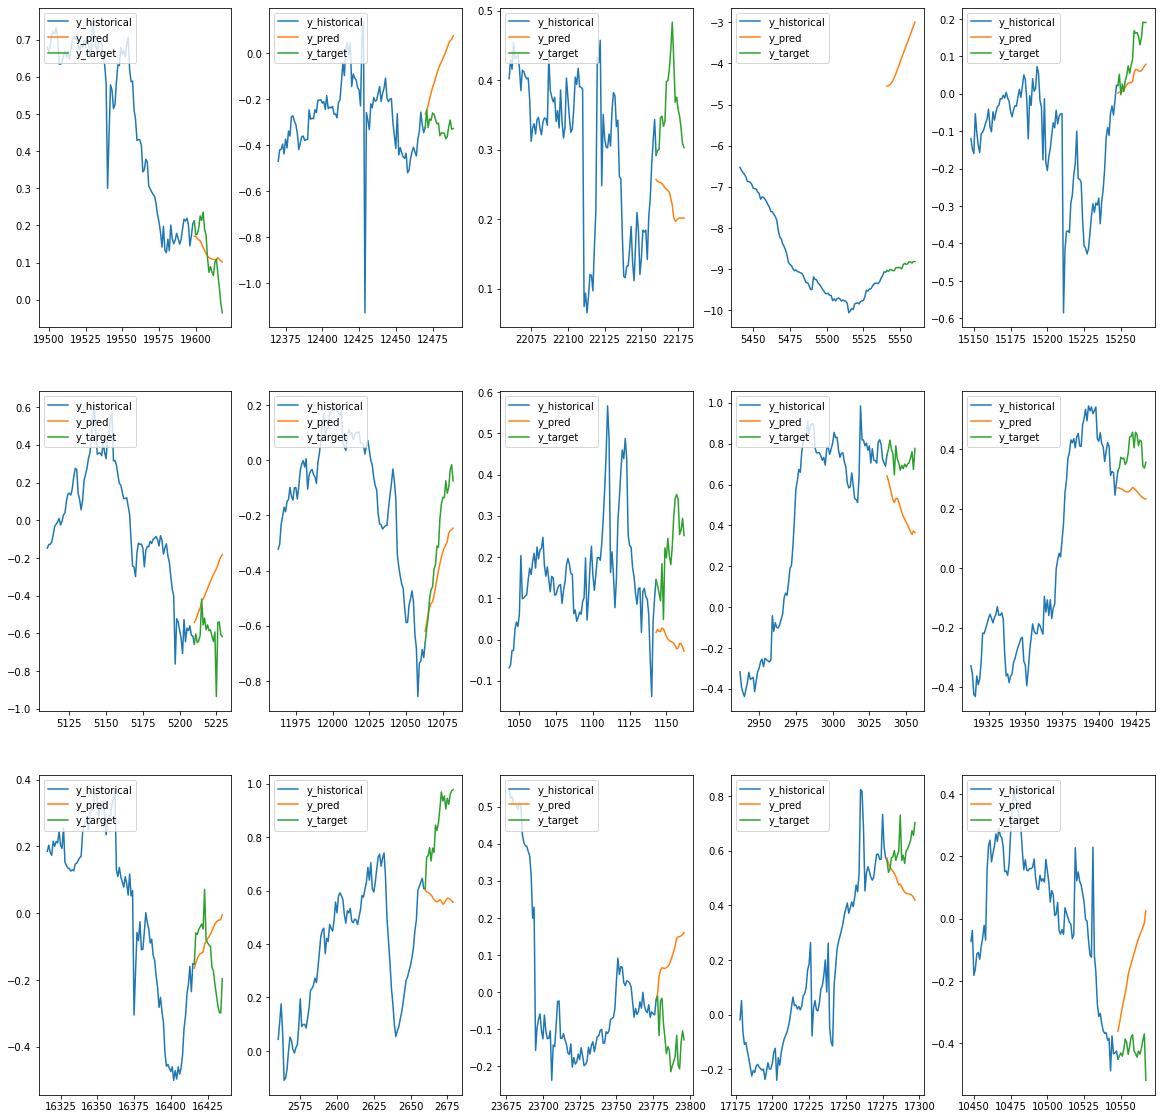

In [10]:
model.forecast_15(x_test, y_test, replace=True, path="./figures/test_set_altered.png")

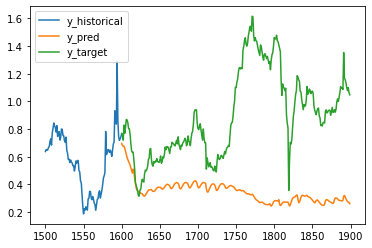

In [9]:
model.forecast_1(x_test, y_test, M=100, n=300, s=1600, replace=True)